In [1]:
import os

os.environ["HTTP_PROXY"] = "http://127.0.0.1:10808"
os.environ["HTTPS_PROXY"] = "http://127.0.0.1:10808"

In [20]:
import os
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.optim import AdamW
from torch.utils.data import Dataset
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

## Load Data

In [ ]:
# # Define the directory
# tsv_dir = '../Article-Bias-Prediction/data/splits/media'
# json_dir = '../Article-Bias-Prediction/data/jsons'

# tsv_files = [f for f in os.listdir(tsv_dir) if f.endswith('.tsv')]

# data_list = []

# for tsv in tsv_files:
#     tsv_path = os.path.join(tsv_dir, tsv)
#     try:
#         df = pd.read_csv(tsv_path, sep='\t')
#         print(f"Successfully read {tsv}")
#     except Exception as e:
#         print(f"Error reading {tsv}: {e}")
    
#     for row in df.itertuples():
#         file_path = os.path.join(json_dir, f"{row.ID}.json")
#         try:
#             with open(file_path, 'r', encoding='utf-8') as f:
#                 data = json.load(f)
#                 data["split"] = tsv.split('.')[0]
#                 data_list.append(data)  # Append JSON data to the list
#         except json.JSONDecodeError:
#             print(f"Error: {file_path} contains invalid JSON!")
#         except Exception as e:
#             print(f"Error reading {file_path}: {e}")
        

# df = pd.DataFrame(data_list)
# df.to_csv('data_media_split.csv', index=False)

Successfully read test.tsv
Successfully read train.tsv


Successfully read valid.tsv


In [48]:
df = pd.read_csv("../data/data_random_split.csv")

In [49]:
df_test = df[df["split"] == "test"].copy()
df_test

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,split
34974,palestine,Breitbart News,2,http://www.breitbart.com/big-journalism/2015/0...,"Obama, Media Lied About Netanyahu and the Pale...",2015-03-20,Ben Shapiro,"For the last several days , the entire Western...","For the last several days, the entire Western ...",www.breitbart.com,right,uI2K5BSCO0LaWuKb,test
34975,federal_budget,ABC News,0,http://abcnews.go.com/blogs/politics/2013/03/w...,Will Fractured House Republicans Unite on Budget?,NaN,John Parkinson,"Tomorrow morning , House Budget Chairman Paul ...","Jacquelyn Martin/AP Photo\n\nTomorrow morning,...",www.abcnews.go.com,left,zeSfcxLilzR0R1Dt,test
34976,fbi,Reuters,1,https://www.reuters.com/article/us-usa-trump-r...,Trump blocks release of Russia memo drafted by...,2018-02-10,Ayesha Rascoe,WASHINGTON ( ███ ) - President Donald Trump on...,WASHINGTON (Reuters) - President Donald Trump ...,www.reuters.com,center,ru8kAxfdPzZc11le,test
34977,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2019/febr...,Trump's North Korea Peace Talks Share Spotligh...,2019-02-25,NaN,"President Donald Trump arrives in Hanoi , Viet...","President Donald Trump arrives in Hanoi, Vietn...",www1.cbn.com,right,TTt5FFmsW6ng3fsC,test
34978,media_bias,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Six Times President Trump Upset Jared Kushner ...,2017-08-20,Adam Shaw,President Trump ’ s fiery response to the even...,President Trump’s fiery response to the events...,www.breitbart.com,right,gYKaZGjLCYdEghTZ,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36269,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2018/augu...,America 'Was Never that Great': NY Gov. Andrew...,2018-08-16,NaN,New York Gov . Andrew Cuomo surprised an audie...,New York Gov. Andrew Cuomo surprised an audien...,www1.cbn.com,right,tx0ljfh22jS6RtHp,test
36270,fbi,Salon,0,http://www.salon.com/2017/05/10/the-fbi-is-ree...,The FBI is reeling from shock of Comey’s unexp...,2017-05-10,Matthew Rozsa,Agents who work for the FBI are reported to be...,Agents who work for the FBI are reported to be...,www.salon.com,left,HFWrdvZbzVjgJU81,test
36271,politics,Newsmax,2,http://www.newsmax.com/Newsfront/loretta-lynch...,Human-Trafficking Bill Fight Could Hold Up Lor...,2015-03-15,NaN,The U.S. Senate majority leader said Sunday he...,The U.S. Senate majority leader said Sunday he...,www.newsmax.com,right,EpeNKrMWiScat2Hm,test
36272,media_bias,The Daily Caller,2,http://dailycaller.com/2016/11/30/fake-news-me...,Fake News: Media Pushes Bogus Survey As Proof ...,2016-11-30,NaN,Multiple U.S. media outlets are citing an onli...,Multiple U.S. media outlets are citing an onli...,www.dailycaller.com,right,o2fN4uERGL363uh0,test


<Axes: title={'center': 'Content Length'}, ylabel='Frequency'>

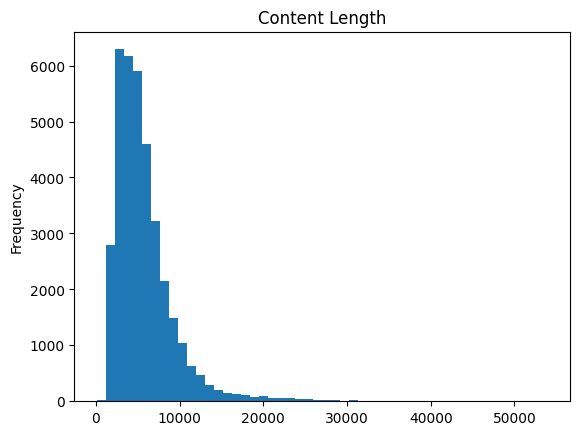

In [4]:
# Plot content length
df['content_length'] = df['content'].apply(len)
df['content_length'].plot.hist(bins=50, title="Content Length")

<Axes: title={'center': 'Size of split=train,val,test'}, xlabel='split'>

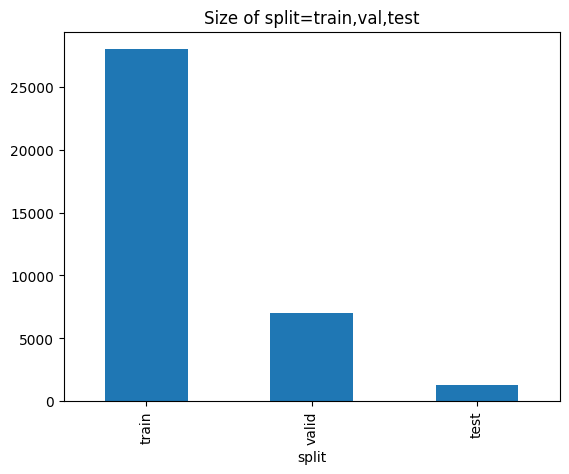

In [5]:
# Plot size of split=train,val,test

df['split'].value_counts().plot(kind='bar', title="Size of split=train,val,test")

<Axes: title={'center': 'Year Distribution'}, ylabel='Frequency'>

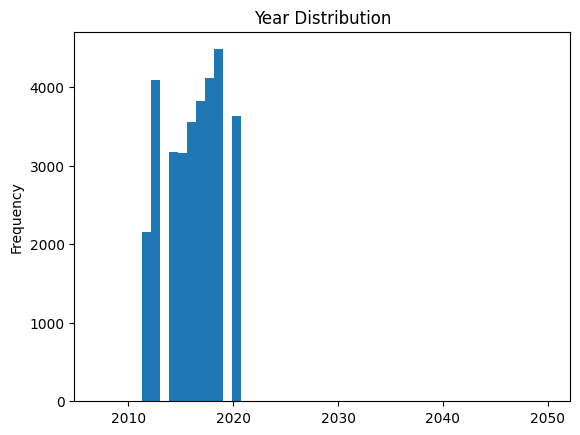

In [28]:
# Plot the year distribution
year_df = df.dropna(subset=['date'])
year_df = year_df[year_df["date"].str.contains("-")]
year_df['year'] = year_df['date'].apply(lambda x: int(x.split('-')[0]))
year_df['year'].plot.hist(bins=50, title="Year Distribution")

## Existing Roberta nodel

In [11]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

repository = "premsa/political-bias-prediction-allsides-BERT"
model = AutoModelForSequenceClassification.from_pretrained(repository)
tokenizer = AutoTokenizer.from_pretrained(repository)
roberta = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    truncation=True,
    max_length=512,
)


Device set to use cuda:0


In [14]:
labels = roberta(df_test["content"].tolist())
labels

[{'label': 'LABEL_2', 'score': 0.7073867321014404},
 {'label': 'LABEL_0', 'score': 0.6330365538597107},
 {'label': 'LABEL_2', 'score': 0.5896987915039062},
 {'label': 'LABEL_2', 'score': 0.7187697291374207},
 {'label': 'LABEL_2', 'score': 0.9384896159172058},
 {'label': 'LABEL_1', 'score': 0.9642848372459412},
 {'label': 'LABEL_2', 'score': 0.6026054620742798},
 {'label': 'LABEL_0', 'score': 0.4852510094642639},
 {'label': 'LABEL_1', 'score': 0.9868680238723755},
 {'label': 'LABEL_0', 'score': 0.6888425350189209},
 {'label': 'LABEL_2', 'score': 0.8533273339271545},
 {'label': 'LABEL_2', 'score': 0.817845344543457},
 {'label': 'LABEL_2', 'score': 0.9450438618659973},
 {'label': 'LABEL_2', 'score': 0.897118330001831},
 {'label': 'LABEL_0', 'score': 0.4954582750797272},
 {'label': 'LABEL_0', 'score': 0.9706498980522156},
 {'label': 'LABEL_0', 'score': 0.8527403473854065},
 {'label': 'LABEL_0', 'score': 0.8620717525482178},
 {'label': 'LABEL_0', 'score': 0.5641849637031555},
 {'label': 'LA

In [15]:
for label in labels:
    label["label"] = int(label["label"][-1])

In [16]:
labels = pd.DataFrame(labels)
df_test = pd.concat([df_test, labels], axis=1)
df_test

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,split,label,score
0,palestine,Breitbart News,2,http://www.breitbart.com/big-journalism/2015/0...,"Obama, Media Lied About Netanyahu and the Pale...",2015-03-20,Ben Shapiro,"For the last several days , the entire Western...","For the last several days, the entire Western ...",www.breitbart.com,right,uI2K5BSCO0LaWuKb,test,2,0.707387
1,federal_budget,ABC News,0,http://abcnews.go.com/blogs/politics/2013/03/w...,Will Fractured House Republicans Unite on Budget?,NaN,John Parkinson,"Tomorrow morning , House Budget Chairman Paul ...","Jacquelyn Martin/AP Photo\n\nTomorrow morning,...",www.abcnews.go.com,left,zeSfcxLilzR0R1Dt,test,0,0.633037
2,fbi,Reuters,1,https://www.reuters.com/article/us-usa-trump-r...,Trump blocks release of Russia memo drafted by...,2018-02-10,Ayesha Rascoe,WASHINGTON ( ███ ) - President Donald Trump on...,WASHINGTON (Reuters) - President Donald Trump ...,www.reuters.com,center,ru8kAxfdPzZc11le,test,2,0.589699
3,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2019/febr...,Trump's North Korea Peace Talks Share Spotligh...,2019-02-25,NaN,"President Donald Trump arrives in Hanoi , Viet...","President Donald Trump arrives in Hanoi, Vietn...",www1.cbn.com,right,TTt5FFmsW6ng3fsC,test,2,0.718770
4,media_bias,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Six Times President Trump Upset Jared Kushner ...,2017-08-20,Adam Shaw,President Trump ’ s fiery response to the even...,President Trump’s fiery response to the events...,www.breitbart.com,right,gYKaZGjLCYdEghTZ,test,2,0.938490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2018/augu...,America 'Was Never that Great': NY Gov. Andrew...,2018-08-16,NaN,New York Gov . Andrew Cuomo surprised an audie...,New York Gov. Andrew Cuomo surprised an audien...,www1.cbn.com,right,tx0ljfh22jS6RtHp,test,2,0.947472
1296,fbi,Salon,0,http://www.salon.com/2017/05/10/the-fbi-is-ree...,The FBI is reeling from shock of Comey’s unexp...,2017-05-10,Matthew Rozsa,Agents who work for the FBI are reported to be...,Agents who work for the FBI are reported to be...,www.salon.com,left,HFWrdvZbzVjgJU81,test,0,0.696791
1297,politics,Newsmax,2,http://www.newsmax.com/Newsfront/loretta-lynch...,Human-Trafficking Bill Fight Could Hold Up Lor...,2015-03-15,NaN,The U.S. Senate majority leader said Sunday he...,The U.S. Senate majority leader said Sunday he...,www.newsmax.com,right,EpeNKrMWiScat2Hm,test,0,0.853401
1298,media_bias,The Daily Caller,2,http://dailycaller.com/2016/11/30/fake-news-me...,Fake News: Media Pushes Bogus Survey As Proof ...,2016-11-30,NaN,Multiple U.S. media outlets are citing an onli...,Multiple U.S. media outlets are citing an onli...,www.dailycaller.com,right,o2fN4uERGL363uh0,test,0,0.955279


In [18]:
# Classification report
from sklearn.metrics import classification_report

print(
    classification_report(
        df_test["bias"],
        df_test["label"],
        target_names=["left", "center", "right"],
    )
)

              precision    recall  f1-score   support

        left       0.49      0.84      0.62       402
      center       0.89      0.37      0.52       299
       right       0.79      0.65      0.71       599

    accuracy                           0.64      1300
   macro avg       0.72      0.62      0.62      1300
weighted avg       0.72      0.64      0.64      1300



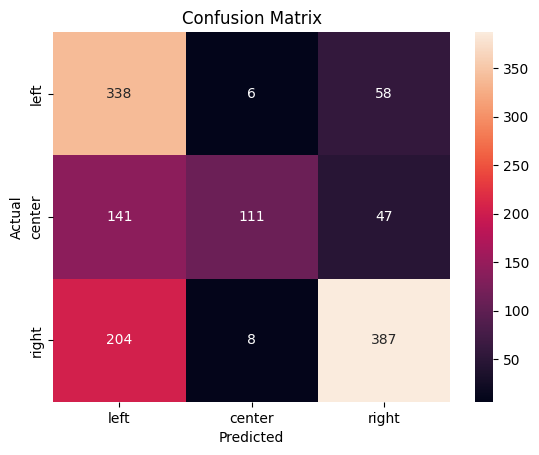

In [20]:
# Confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(df_test["bias"], df_test["label"])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["left", "center", "right"], yticklabels=["left", "center", "right"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Existing Llama Model

In [30]:
# 1. Load the *base* LLaMA model for sequence classification
base_model_name = "meta-llama/Llama-3.2-1B"
tokenizer_name = "tokenizer"
access_token = os.environ.get("HF_TOKEN")

model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    token=access_token,
    num_labels=3,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# 2. Load the LoRA adapter on top of the base model
adapter_path = "tzoulio/news-bias-finder-llama-3.2-1B"
model = PeftModel.from_pretrained(model, adapter_path)

# 3. Create the pipeline with the specified model and tokenizer
pipeline = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer
)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
This can be used to load a bitsandbytes version that is different from the PyTorch CUDA version.
If this was unintended set the BNB_CUDA_VERSION variable to an empty string: export BNB_CUDA_VERSION=
If you use the manual override make sure the right libcudart.so is in your LD_LIBRARY_PATH
For example by adding the following to your .bashrc: export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:<path_to_cuda_dir/lib64

Device set to use cuda:0
The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 

In [ ]:
# Evaluate the model
labels = pipeline(df_test["content"].tolist())

In [32]:
for label in labels:
    label["label"] = int(label["label"][-1])

labels = pd.DataFrame(labels)
df_test = pd.concat([df_test, labels], axis=1)
df_test

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,split,label,score
0,palestine,Breitbart News,2,http://www.breitbart.com/big-journalism/2015/0...,"Obama, Media Lied About Netanyahu and the Pale...",2015-03-20,Ben Shapiro,"For the last several days , the entire Western...","For the last several days, the entire Western ...",www.breitbart.com,right,uI2K5BSCO0LaWuKb,test,2,0.999961
1,federal_budget,ABC News,0,http://abcnews.go.com/blogs/politics/2013/03/w...,Will Fractured House Republicans Unite on Budget?,NaN,John Parkinson,"Tomorrow morning , House Budget Chairman Paul ...","Jacquelyn Martin/AP Photo\n\nTomorrow morning,...",www.abcnews.go.com,left,zeSfcxLilzR0R1Dt,test,0,0.936256
2,fbi,Reuters,1,https://www.reuters.com/article/us-usa-trump-r...,Trump blocks release of Russia memo drafted by...,2018-02-10,Ayesha Rascoe,WASHINGTON ( ███ ) - President Donald Trump on...,WASHINGTON (Reuters) - President Donald Trump ...,www.reuters.com,center,ru8kAxfdPzZc11le,test,1,1.000000
3,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2019/febr...,Trump's North Korea Peace Talks Share Spotligh...,2019-02-25,NaN,"President Donald Trump arrives in Hanoi , Viet...","President Donald Trump arrives in Hanoi, Vietn...",www1.cbn.com,right,TTt5FFmsW6ng3fsC,test,2,1.000000
4,media_bias,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Six Times President Trump Upset Jared Kushner ...,2017-08-20,Adam Shaw,President Trump ’ s fiery response to the even...,President Trump’s fiery response to the events...,www.breitbart.com,right,gYKaZGjLCYdEghTZ,test,2,0.999834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2018/augu...,America 'Was Never that Great': NY Gov. Andrew...,2018-08-16,NaN,New York Gov . Andrew Cuomo surprised an audie...,New York Gov. Andrew Cuomo surprised an audien...,www1.cbn.com,right,tx0ljfh22jS6RtHp,test,2,0.999970
1296,fbi,Salon,0,http://www.salon.com/2017/05/10/the-fbi-is-ree...,The FBI is reeling from shock of Comey’s unexp...,2017-05-10,Matthew Rozsa,Agents who work for the FBI are reported to be...,Agents who work for the FBI are reported to be...,www.salon.com,left,HFWrdvZbzVjgJU81,test,0,0.985097
1297,politics,Newsmax,2,http://www.newsmax.com/Newsfront/loretta-lynch...,Human-Trafficking Bill Fight Could Hold Up Lor...,2015-03-15,NaN,The U.S. Senate majority leader said Sunday he...,The U.S. Senate majority leader said Sunday he...,www.newsmax.com,right,EpeNKrMWiScat2Hm,test,2,0.998259
1298,media_bias,The Daily Caller,2,http://dailycaller.com/2016/11/30/fake-news-me...,Fake News: Media Pushes Bogus Survey As Proof ...,2016-11-30,NaN,Multiple U.S. media outlets are citing an onli...,Multiple U.S. media outlets are citing an onli...,www.dailycaller.com,right,o2fN4uERGL363uh0,test,2,0.999900


In [33]:
# Classification report
print(
    classification_report(
        df_test["bias"],
        df_test["label"],
        target_names=["left", "center", "right"],
    )
)

              precision    recall  f1-score   support

        left       0.96      0.96      0.96       402
      center       0.95      0.99      0.97       299
       right       0.98      0.96      0.97       599

    accuracy                           0.97      1300
   macro avg       0.97      0.97      0.97      1300
weighted avg       0.97      0.97      0.97      1300



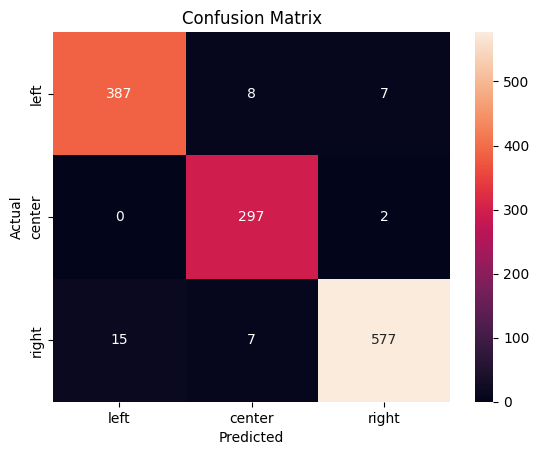

In [34]:
# Confusion matrix
cm = confusion_matrix(df_test["bias"], df_test["label"])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["left", "center", "right"], yticklabels=["left", "center", "right"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Finetune Llama Model

In [39]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

In [41]:
df = pd.read_csv("../data/data_random_split.csv")

In [5]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
) # setup bits and bytes config

# Load tokenizer
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, quantization_config=bnb_config, num_labels=3)

# Set pad token
tokenizer.add_special_tokens({"pad_token":"[PAD]"})
model.config.pad_token_id = tokenizer.pad_token_id
model.resize_token_embeddings(len(tokenizer))

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model) # prepares the whole model for kbit training

config = LoraConfig(
    r=8, 
    lora_alpha=32, 
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, config) # Now you get a model ready for QLoRA training

This can be used to load a bitsandbytes version that is different from the PyTorch CUDA version.
If this was unintended set the BNB_CUDA_VERSION variable to an empty string: export BNB_CUDA_VERSION=
If you use the manual override make sure the right libcudart.so is in your LD_LIBRARY_PATH
For example by adding the following to your .bashrc: export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:<path_to_cuda_dir/lib64

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_re

In [6]:
# Label mapping
label_map = {"left": 0, "center": 1, "right": 2}

# Custom Dataset
class TextClassificationDataset(Dataset):
    def __init__(self, data, label_map, tokenizer):
        self.data = data
        self.label_map = label_map
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]["content"]
        label = self.data.iloc[idx]["bias"]  # Map label correctly
        return {"text": text, "label": label}

# Dynamic Padding in DataLoader
def collate_fn(batch):
    texts = [item["text"] for item in batch]
    labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)

    # Apply dynamic padding
    tokenized = tokenizer(
        texts,
        padding=True,  # Enable dynamic padding
        truncation=True,
        return_tensors="pt"
    )

    return {
        "input_ids": tokenized["input_ids"],
        "attention_mask": tokenized["attention_mask"],
        "labels": labels
    }
    
train_dataset = TextClassificationDataset(df[df["split"] == "train"], label_map, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn)

val_dataset = TextClassificationDataset(df[df["split"] == "valid"], label_map, tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=4, collate_fn=collate_fn)

# Test the DataLoader
batch = next(iter(train_dataloader))
print(batch)


{'input_ids': tensor([[128000,  13622,  35748,  ..., 128256, 128256, 128256],
        [128000,    791,  56527,  ..., 128256, 128256, 128256],
        [128000,  12487,   7424,  ...,    279,  26969,    662],
        [128000,  48414,   5513,  ..., 128256, 128256, 128256]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([0, 2, 2, 1])}


In [ ]:
from accelerate import Accelerator

# Initialize accelerator
accelerator = Accelerator()
device = accelerator.device

# Wrap model & optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)
model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

num_epochs = 3
log_steps = 10  # Log loss every `n` steps

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        # Move batch to the correct device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        accelerator.backward(loss)
        optimizer.step()

        total_loss += loss.item()

        if (step + 1) % log_steps == 0:
            print(f"Epoch {epoch + 1}, Step {step + 1}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

print("Training complete!")


In [ ]:
text = ["Government policies should be more inclusive."]
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

# Get predictions
outputs = model(**inputs)
outputs

## Finetuned Llama Evaluation

In [21]:
# 1. Load the *base* LLaMA model for sequence classification
base_model_name = "meta-llama/Llama-3.2-1B"
tokenizer_name = "tokenizer"
access_token = os.environ.get("HF_TOKEN")

model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    token=access_token,
    num_labels=3,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# Set pad token
tokenizer.add_special_tokens({"pad_token":"[PAD]"})
model.config.pad_token_id = tokenizer.pad_token_id
model.resize_token_embeddings(len(tokenizer))

# 2. Load the LoRA adapter on top of the base model
adapter_path = "best_model/best_model_r16_b4"
model = PeftModel.from_pretrained(model, adapter_path)

# 3. Create the pipeline with the specified model and tokenizer
pipeline = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer
)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
Device set to use cuda:0
The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSeq

In [55]:
df_test = df[df["split"] == "test"].copy()

In [51]:
# Evaluate the model
labels = pipeline(df_test["content_original"].tolist())

In [52]:
for label in labels:
    label["label"] = int(label["label"][-1])

In [56]:
labels = pd.DataFrame(labels)
df_test = pd.concat([df_test.reset_index(drop=False), labels], axis=1)
df_test

,index,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,split,label,score
0,34974,palestine,Breitbart News,2,http://www.breitbart.com/big-journalism/2015/0...,"Obama, Media Lied About Netanyahu and the Pale...",2015-03-20,Ben Shapiro,"For the last several days , the entire Western...","For the last several days, the entire Western ...",www.breitbart.com,right,uI2K5BSCO0LaWuKb,test,2,0.999698
1,34975,federal_budget,ABC News,0,http://abcnews.go.com/blogs/politics/2013/03/w...,Will Fractured House Republicans Unite on Budget?,NaN,John Parkinson,"Tomorrow morning , House Budget Chairman Paul ...","Jacquelyn Martin/AP Photo\n\nTomorrow morning,...",www.abcnews.go.com,left,zeSfcxLilzR0R1Dt,test,0,0.974455
2,34976,fbi,Reuters,1,https://www.reuters.com/article/us-usa-trump-r...,Trump blocks release of Russia memo drafted by...,2018-02-10,Ayesha Rascoe,WASHINGTON ( ███ ) - President Donald Trump on...,WASHINGTON (Reuters) - President Donald Trump ...,www.reuters.com,center,ru8kAxfdPzZc11le,test,1,0.999698
3,34977,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2019/febr...,Trump's North Korea Peace Talks Share Spotligh...,2019-02-25,NaN,"President Donald Trump arrives in Hanoi , Viet...","President Donald Trump arrives in Hanoi, Vietn...",www1.cbn.com,right,TTt5FFmsW6ng3fsC,test,2,0.494206
4,34978,media_bias,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Six Times President Trump Upset Jared Kushner ...,2017-08-20,Adam Shaw,President Trump ’ s fiery response to the even...,President Trump’s fiery response to the events...,www.breitbart.com,right,gYKaZGjLCYdEghTZ,test,2,0.999234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,36269,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2018/augu...,America 'Was Never that Great': NY Gov. Andrew...,2018-08-16,NaN,New York Gov . Andrew Cuomo surprised an audie...,New York Gov. Andrew Cuomo surprised an audien...,www1.cbn.com,right,tx0ljfh22jS6RtHp,test,2,0.967727
1296,36270,fbi,Salon,0,http://www.salon.com/2017/05/10/the-fbi-is-ree...,The FBI is reeling from shock of Comey’s unexp...,2017-05-10,Matthew Rozsa,Agents who work for the FBI are reported to be...,Agents who work for the FBI are reported to be...,www.salon.com,left,HFWrdvZbzVjgJU81,test,0,0.998774
1297,36271,politics,Newsmax,2,http://www.newsmax.com/Newsfront/loretta-lynch...,Human-Trafficking Bill Fight Could Hold Up Lor...,2015-03-15,NaN,The U.S. Senate majority leader said Sunday he...,The U.S. Senate majority leader said Sunday he...,www.newsmax.com,right,EpeNKrMWiScat2Hm,test,2,0.979656
1298,36272,media_bias,The Daily Caller,2,http://dailycaller.com/2016/11/30/fake-news-me...,Fake News: Media Pushes Bogus Survey As Proof ...,2016-11-30,NaN,Multiple U.S. media outlets are citing an onli...,Multiple U.S. media outlets are citing an onli...,www.dailycaller.com,right,o2fN4uERGL363uh0,test,2,0.998909


In [57]:
import csv

df_test.to_csv("../data/data_random_split_llama.csv", encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)

In [68]:
incorrect = df_test[df_test["label"] != df_test["bias"]]

incorrect[["index", "source", "bias", "label", "content_original"]].to_json("../data/data_random_split_llama.json", orient="records")

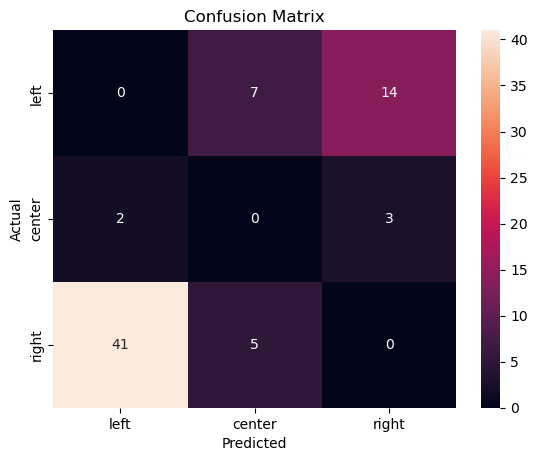

In [65]:
# Confusion matrix for incorrect samples

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(6.5, 5), dpi=100)

cm = confusion_matrix(incorrect["bias"], incorrect["label"])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["left", "center", "right"], yticklabels=["left", "center", "right"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [64]:
# Classification report
from sklearn.metrics import classification_report

print(
    classification_report(
        df_test["bias"],
        df_test["label"],
        target_names=["left", "center", "right"],
    )
)

              precision    recall  f1-score   support

        left       0.90      0.95      0.92       402
      center       0.96      0.98      0.97       299
       right       0.97      0.92      0.95       599

    accuracy                           0.94      1300
   macro avg       0.94      0.95      0.95      1300
weighted avg       0.95      0.94      0.94      1300



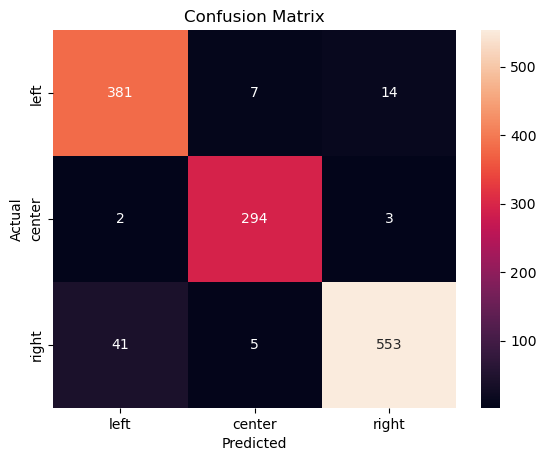

In [81]:
# Confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(6.5, 5), dpi=100)

cm = confusion_matrix(df_test["bias"], df_test["label"])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["left", "center", "right"], yticklabels=["left", "center", "right"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Classifying articles in the Wild

In [3]:
import os
import pandas as pd

In [4]:
df_sample = pd.read_csv("../data/ai_articles.csv")

In [5]:
df_sample = df_sample.reset_index(drop=False)

In [6]:
df_sample = df_sample[df_sample["lang"] == "en"]
df_sample = df_sample.dropna(subset=["article_text"])

In [140]:
# 1. Load the *base* LLaMA model for sequence classification
base_model_name = "meta-llama/Llama-3.2-1B"
tokenizer_name = "tokenizer"
access_token = os.environ.get("HF_TOKEN")

model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    token=access_token,
    num_labels=3,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# Set pad token
tokenizer.add_special_tokens({"pad_token":"[PAD]"})
model.config.pad_token_id = tokenizer.pad_token_id
model.resize_token_embeddings(len(tokenizer))

# 2. Load the LoRA adapter on top of the base model
adapter_path = "best_model/best_model_r16_b4"
model = PeftModel.from_pretrained(model, adapter_path)

# 3. Create the pipeline with the specified model and tokenizer
pipeline = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer
)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0
The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DiffLlamaForSequenceClassification', 'DistilBe

In [8]:
class ListDataset(Dataset):
    def __init__(self, original_list):
        self.original_list = original_list

    def __len__(self):
        return len(self.original_list)

    def __getitem__(self, i):
        return self.original_list[i]

list_dataset = ListDataset(df_sample["article_text"].tolist())

In [9]:
labels = []

for label in tqdm(pipeline(list_dataset)):
    labels.append(label)

labels[:10]

  0%|          | 1/76178 [00:00<4:21:46,  4.85it/s]

100%|██████████| 76178/76178 [2:04:17<00:00, 10.21it/s]   


[{'label': 'LABEL_0', 'score': 0.5431602597236633},
 {'label': 'LABEL_2', 'score': 0.7561769485473633},
 {'label': 'LABEL_2', 'score': 0.6104245781898499},
 {'label': 'LABEL_2', 'score': 0.9915364980697632},
 {'label': 'LABEL_2', 'score': 0.5214601755142212},
 {'label': 'LABEL_1', 'score': 0.9983677268028259},
 {'label': 'LABEL_2', 'score': 0.9848135113716125},
 {'label': 'LABEL_1', 'score': 0.865553081035614},
 {'label': 'LABEL_0', 'score': 0.9348810315132141},
 {'label': 'LABEL_2', 'score': 0.9432687759399414}]

In [10]:
for label in labels:
    label["label"] = int(label["label"][-1])

In [11]:
labels = pd.DataFrame(labels)
labels.rename(columns={"label": "llama_bias"}, inplace=True)

In [12]:
len(labels), len(df_sample)

(76178, 76178)

In [13]:
df_sample = df_sample.reset_index(drop=True)

In [14]:
df_sample_labeled = pd.concat([df_sample, labels], axis=1)
df_sample_labeled

,index,interest_slug,story_id,title,description,date,url,lang,paywall,source_name,...,source_lon,source_place,article_title,article_description,article_image_url,article_text,article_date_publish,article_authors,llama_bias,score
0,1,ai,rss_10567_1740461771022_4,DeepSeek’s AI models boost Nvidia chip demand ...,"Tencent, Alibaba and ByteDance are said to hav...",2025-02-25T01:59:54.000Z,https://www.scmp.com/tech/big-tech/article/329...,en,yes,South China Morning Post,...,114.096992,Hong Kong,DeepSeek’s AI models drive surging orders for ...,"Tencent, Alibaba and ByteDance are said to hav...",https://cdn.i-scmp.com/sites/default/files/sty...,"The surge in orders, which is being reported f...",2025-02-25 00:00:00,NaN,0,0.543160
1,2,ai,rss_10567_1740461771022_4,Nvidia Sees Rush For H20 AI Chip Orders As Dee...,"Chinese tech giants Tencent, Alibaba, and Byte...",2025-02-25T02:23:42.000Z,https://www.benzinga.com/25/02/43931074/chines...,en,sometimes,Benzinga,...,-73.975301,"New York, New York, United States",Nvidia Sees Rush For H20 AI Chip Orders As Dee...,"Chinese tech giants Tencent, Alibaba, and Byte...",https://cdn.benzinga.com/files/images/story/20...,"Chinese tech giants Tencent Holdings TCEHY, Al...",2025-02-24 21:23:42,Ananya Gairola,2,0.756177
2,3,ai,rss_10567_1740461771022_4,Nvidia gets a DeepSeek-inspired boost in China...,Nvidia’s H20 chips are in high demand in China...,2025-02-25T15:59:09.000Z,https://fortune.com/2025/02/25/nvidia-china-de...,en,yes,Fortune,...,-73.980030,"New York, New York, United States",Nvidia gets a DeepSeek-inspired boost in China...,Nvidia’s H20 chips are in high demand in China...,https://fortune.com/img-assets/wp-content/uplo...,© 2025 Fortune Media IP Limited. All Rights Re...,2025-02-25 15:59:09,Beatrice Nolan,2,0.610425
3,4,ai,rss_10567_1740461771022_4,"Alibaba, ByteDance, and Tencent boost orders f...",Nvidia's H20 chip gains traction in China amid...,2025-02-25T07:54:16.000Z,https://seekingalpha.com/news/4412923-alibaba-...,en,no,Seeking Alpha,...,-95.506712,United States,"Alibaba, ByteDance, and Tencent boost orders f...",Nvidia's H20 chip gains traction in China amid...,https://static.seekingalpha.com/cdn/s3/uploads...,( 2min )\nChinese companies are increasingly p...,2025-02-25 07:54:16,Arundhati Sarkar,2,0.991536
4,5,ai,rss_10567_1740461771022_4,"Sources: Tencent, Alibaba, ByteDance, and othe...",Top news and commentary for technology's leade...,2025-02-25T13:15:34.000Z,http://www.techmeme.com/250225/p17,en,no,Techmeme,...,-119.400820,"California, United States","Techmeme: Sources: Tencent, Alibaba, ByteDance...",Top news and commentary for technology's leade...,https://www.reuters.com/resizer/v2/EIP5MPMKXJP...,About This Page\nThis is a Techmeme archive pa...,NaN,NaN,2,0.521460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76173,109638,ai,rss_25139_1737979365756_29,Lambda Labs' COO has left the AI cloud provide...,Mitesh Agrawal has moved on from Lambda Labs f...,2025-01-27T11:11:02.000Z,https://www.businessinsider.com/lambda-labs-co...,en,yes,Business Insider,...,-95.803133,United States,"Lambda Labs' COO Has Left for Positron, a Star...",Mitesh Agrawal is leaving Lambda Labs to head ...,https://i.insider.com/6796a577eb4be2fff9a22cee...,Lambda Labs' Mitesh Agrawal left to head the A...,2025-01-27 11:11:02,Lakshmi Varanasi,2,0.821254
76174,109639,ai,rss_25139_1737979365756_29,Lambda Labs’ COO has left the AI cloud provide...,"Lambda Labs, a Nvidia partner, has lost its ch...",2025-01-27T11:26:07.000Z,https://dnyuz.com/2025/01/27/lambda-labs-coo-h...,en,no,DNyuz,...,NaN,NaN,Lambda Labs’ COO has left the AI cloud provide...,"Lambda Labs, a Nvidia partner, has lost its ch...",https://dnyuz.com/wp-content/uploads/2025/01/L...,"Lambda Labs, a Nvidia partner, has lost its ch...",2025-01-27 07:26:07,Business Insider; www.facebook.com,2,0.762517
76175,109641,ai,rss_19797_1737976475535_4,3 best AI altcoins under $1 that could deliver...,If you’re try

In [15]:
df_sample_labeled["llama_bias"].value_counts()

llama_bias
2    35095
0    26588
1    14495
Name: count, dtype: int64

In [16]:
import csv

df_sample_labeled.to_csv("../data/ai_articles_llama.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

### Prediction analysis

In [2]:
import pandas as pd

In [19]:
df_topic = pd.read_csv("../data/ai_articles_llama.csv")
df_topic = df_topic[df_topic["article_text"].str.len() > 512]

In [20]:
df_topic["source_bias"].value_counts()

source_bias
unknown      46062
center        9012
leanLeft      6433
leanRight     3405
right         1901
left           876
farRight       470
farLeft         36
Name: count, dtype: int64

In [21]:
source_bias_map = {
    "farLeft": 0,
    "left": 0,
    "leanLeft": 0,
    "center": 1,
    "leanRight": 2,
    "right": 2,
    "farRight": 2,
    "unknown": -1
}
df_topic["source_bias_num"] = df_topic["source_bias"].map(source_bias_map)

In [22]:
df_topic_gt = df_topic[df_topic["source_bias_num"] != -1]
source_biases = df_topic_gt["source_bias_num"].tolist()
llama_biases = df_topic_gt["llama_bias"].tolist()

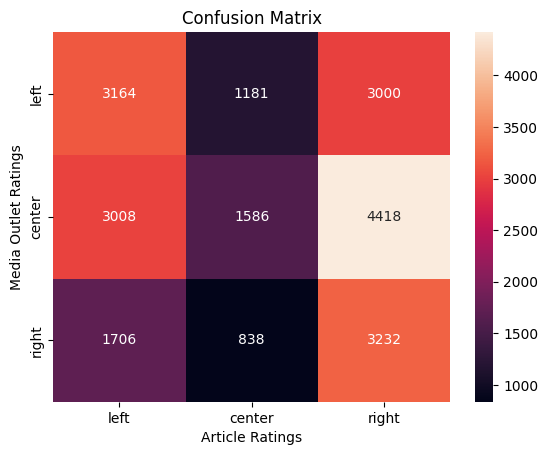

In [23]:
# Confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(source_biases, llama_biases)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["left", "center", "right"], yticklabels=["left", "center", "right"])
plt.xlabel("Article Ratings")
plt.ylabel("Media Outlet Ratings")
plt.title("Confusion Matrix")
plt.show()

In [25]:
df_topic["source_name"].value_counts().head(20)

source_name
TechCrunch                  537
Bitcoin Ethereum News       442
Benzinga                    383
CNBC                        339
NDTV Gadgets 360            316
SiliconANGLE                312
Cryptopolitan               301
Business Insider            298
The Independent             273
Tech Radar                  263
Channel News Asia           262
Android Headlines           259
Business Times              258
NDTV                        252
South China Morning Post    248
DNyuz                       246
Analytics India Magazine    236
The Straits Times           212
VentureBeat                 211
Firstpost News              211
Name: count, dtype: int64

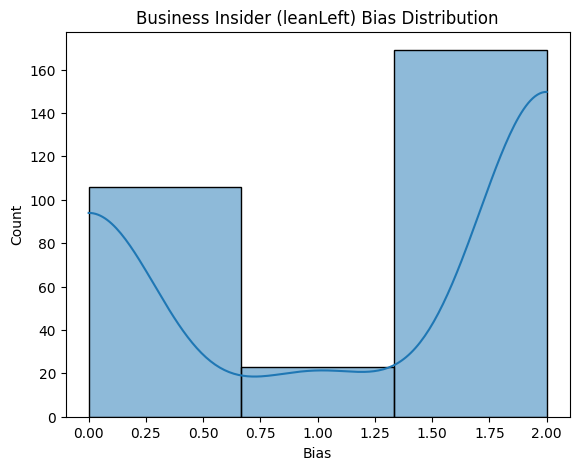

In [28]:
def plot_media(name):
    media = df_topic[df_topic["source_name"] == name]
    source_bias = media["source_bias"].iloc[0]

    plt.figure(figsize=(6.5, 5), dpi=100)
    sns.histplot(data=media, x="llama_bias", bins=3, kde=True)
    plt.title(f"{name} ({source_bias}) Bias Distribution")
    plt.xlabel("Bias")
    plt.ylabel("Count")
    plt.show()

plot_media("Business Insider")

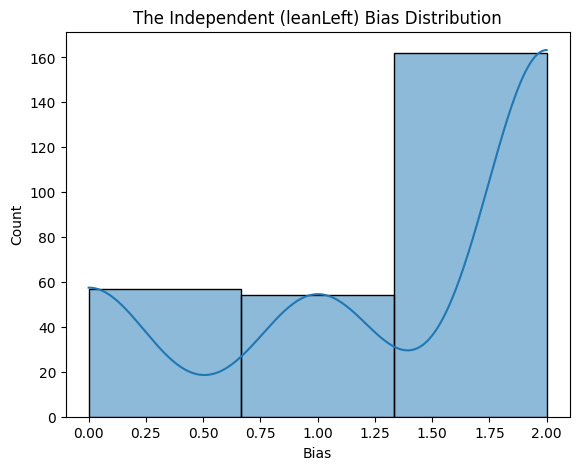

In [35]:
plot_media("The Independent")

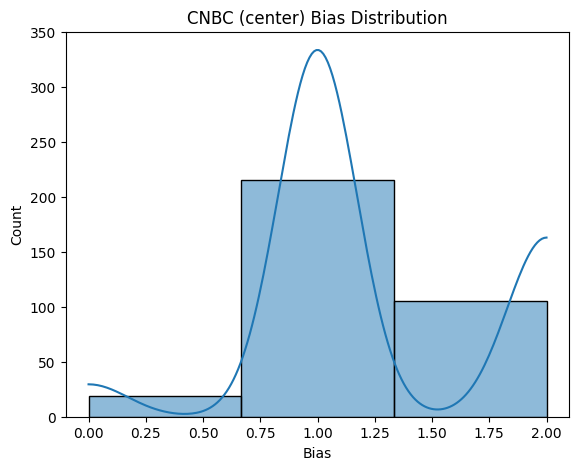

In [31]:
plot_media("CNBC")

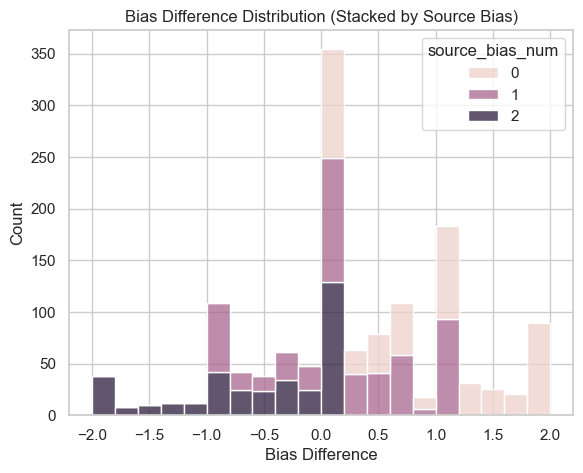

In [56]:
# Plot the relationship between source_bias and llama_bias in one plot
# For every media, calculate average llama_bias

media_bias = df_topic[df_topic["source_bias"] != "unknown"] \
    .groupby("source_name").agg({
    "source_bias_num": lambda x: x.mode(),
    "llama_bias": "mean"}).reset_index()

# Calculate the difference between source_bias and mean llama_bias
media_bias["bias_diff"] = media_bias["llama_bias"] - media_bias["source_bias_num"]

# Plot the distribution of bias_diff for each source_bias_num
plt.figure(figsize=(6.5, 5), dpi=100)
sns.histplot(
    data=media_bias, 
    x="bias_diff", 
    hue="source_bias_num",  # Color by source_bias_num
    bins=20, 
    multiple="stack"        # Stacked bars
)
plt.title("Bias Difference Distribution (Stacked by Source Bias)")
plt.xlabel("Bias Difference")
plt.ylabel("Count")
plt.show()


### DeepSeek Labeling

In [3]:
import pandas as pd

In [4]:
df_10k = pd.read_csv("../data/topics_10k/topics_10k.csv")

In [5]:
df_10k.head()

,id,interest_slug,story_id,title,description,date,url,lang,paywall,source_name,...,source_lat,source_lon,source_place,article_file,article_title,article_description,article_image_url,article_text,article_date_publish,article_authors
0,0,california-politics,ec08507a-0644-497a-8933-857281f6a95e,Los Angeles wildfires death toll rises as crew...,LOS ANGELES (AP) — The death toll from the wil...,2025-01-12T14:06:00.000Z,https://wtop.com/national/2025/01/los-angeles-...,en,no,Washington Top News,...,38.897679,-77.051110,"Washington, District of Columbia, United States",data/topics/json/416788.json,24 dead as fire crews try to corral Los Angele...,Firefighters scrambled Sunday to make further ...,https://wtop.com/national/2025/01/los-angeles-...,The National Weather Service issued red flag w...,2025-01-12 10:30:17,The Associated Press
1,1,big-ten,96c4a21f-2008-4d50-b29e-67ad8728dd31,Twelve-team playoff not big enough to avoid co...,"The new, 12-team College Football Playoff brin...",2024-12-08T22:40:20.000Z,https://www.limaohio.com/sports/2024/12/08/twe...,en,no,The Lima News,...,34.234545,-84.482904,"Cherokee County, Georgia, United States",data/topics/json/25427.json,team playoff not big enough to avoid controver...,"The new, 12-team College Football Playoff brin...",https://www.limaohio.com/wp-content/uploads/20...,"The new, 12-team College Football Playoff brin...",2024-12-08 22:40:20,Associated Press; www.limaohio.com
2,2,california-united-states,20855826-624f-4796-86c1-3bea0fd00649,LA mayor dismisses fire chief over response to...,"Six weeks after devastating wildfires, Los Ang...",2025-02-21T20:27:00.000Z,https://www.wdsu.com/article/los-angeles-mayor...,en,no,WDSU,...,29.951430,-90.071742,"New Orleans, Orleans Parish, Louisiana, United...",data/topics/json/56984.json,LA Mayor Ousts Fire Chief Over Wildfire,Mayor Karen Bass removes Fire Chief Kristin Cr...,https://kubrick.htvapps.com/htv-prod-media.s3....,that doesn't live there. Lynn McIntyre is one ...,2025-02-21 20:28:00,MICHAEL BLOOD
3,3,gaming_d04843,35df203e-aeae-4bc4-86f2-d4d4a588c392,"Jason Momoa to play Lobo in new DC Universe, w...",The DC universe has cast another major role. J...,2024-12-30T10:18:14.000Z,https://www.digitaltrends.com/movies/jason-mom...,en,no,Digital Trends,...,35.642134,-92.654776,United States,data/topics/json/325673.json,"Jason Momoa to play Lobo in new DC Universe, w...",The DC universe has cast another major role. J...,https://www.digitaltrends.com/wp-content/uploa...,Aquaman has left the building.\nAfter starring...,2024-12-30 10:18:14,Dan Girolamo
4,4,2024-uk-election,370af72e-6a83-44a1-be1f-93175c43ab5f,UK Prime Minister Commits to Deploying Troops ...,"LONDON, ENGLAND (VINnews)-Prime Minister Keir ...",2025-02-17T12:40:57.000Z,https://vinnews.com/2025/02/17/uk-prime-minist...,en,no,VINnews,...,NaN,NaN,NaN,data/topics/json/66043.json,UK Prime Minister Commits to Deploying Troops ...,"LONDON, ENGLAND (VINnews)-Prime Minister Keir ...",https://vinnews.com/wp-content/uploads/2025/02...,"LONDON, ENGLAND (VINnews)-Prime Minister Keir ...",2025-02-20 00:00:00,Reuven Rosenfeld


In [6]:
label_files = [
    "../data/topics_10k/topics_10k_ideology_20250308_154650.jsonl",
    "../data/topics_10k/topics_10k_ideology_20250308_175522.jsonl"
]

data = []

for file in label_files:
    with open(file, "r", encoding="utf-8") as f:
        for line in f:
            entry = json.loads(line)
            data.append(entry)

df_labels = pd.DataFrame(data)
            

In [7]:
df_labels.head()

,doc_id,score,label,url,reasoning
0,3,0.0,center,https://www.digitaltrends.com/movies/jason-mom...,```markdown\nReasoning:\n\n- **Potentially Bia...
1,4,0.8,center-right,https://vinnews.com/2025/02/17/uk-prime-minist...,```markdown\nReasoning:\n\n- **Potentially Bia...
2,8,-0.5,left-center,https://ny1.com/nyc/all-boroughs/business/2025...,```markdown\nReasoning:\n\n**Potentially Biase...
3,9,-0.1,center,https://www.theglobeandmail.com/world/article-...,```markdown\nReasoning:\n\n- **Potentially Bia...
4,13,1.4,center-right,https://www.upi.com/Top_News/US/2025/02/11/DOJ...,```markdown\nReasoning:\n\n- **Potentially Bia...


In [8]:
df_10k_merged = df_10k.merge(df_labels.drop(columns=["doc_id"]), how="left", on="url")

In [9]:
df_10k_merged.head()

,id,interest_slug,story_id,title,description,date,url,lang,paywall,source_name,...,article_file,article_title,article_description,article_image_url,article_text,article_date_publish,article_authors,score,label,reasoning
0,0,california-politics,ec08507a-0644-497a-8933-857281f6a95e,Los Angeles wildfires death toll rises as crew...,LOS ANGELES (AP) — The death toll from the wil...,2025-01-12T14:06:00.000Z,https://wtop.com/national/2025/01/los-angeles-...,en,no,Washington Top News,...,data/topics/json/416788.json,24 dead as fire crews try to corral Los Angele...,Firefighters scrambled Sunday to make further ...,https://wtop.com/national/2025/01/los-angeles-...,The National Weather Service issued red flag w...,2025-01-12 10:30:17,The Associated Press,-0.5,left-center,```markdown\nReasoning:\n\n- **Potentially Bia...
1,1,big-ten,96c4a21f-2008-4d50-b29e-67ad8728dd31,Twelve-team playoff not big enough to avoid co...,"The new, 12-team College Football Playoff brin...",2024-12-08T22:40:20.000Z,https://www.limaohio.com/sports/2024/12/08/twe...,en,no,The Lima News,...,data/topics/json/25427.json,team playoff not big enough to avoid controver...,"The new, 12-team College Football Playoff brin...",https://www.limaohio.com/wp-content/uploads/20...,"The new, 12-team College Football Playoff brin...",2024-12-08 22:40:20,Associated Press; www.limaohio.com,0.0,center,```markdown\nReasoning:\n\n- **Potentially Bia...
2,2,california-united-states,20855826-624f-4796-86c1-3bea0fd00649,LA mayor dismisses fire chief over response to...,"Six weeks after devastating wildfires, Los Ang...",2025-02-21T20:27:00.000Z,https://www.wdsu.com/article/los-angeles-mayor...,en,no,WDSU,...,data/topics/json/56984.json,LA Mayor Ousts Fire Chief Over Wildfire,Mayor Karen Bass removes Fire Chief Kristin Cr...,https://kubrick.htvapps.com/htv-prod-media.s3....,that doesn't live there. Lynn McIntyre is one ...,2025-02-21 20:28:00,MICHAEL BLOOD,0.4,center-right,```markdown\nReasoning:\n\n- **Potentially Bia...
3,3,gaming_d04843,35df203e-aeae-4bc4-86f2-d4d4a588c392,"Jason Momoa to play Lobo in new DC Universe, w...",The DC universe has cast another major role. J...,2024-12-30T10:18:14.000Z,https://www.digitaltrends.com/movies/jason-mom...,en,no,Digital Trends,...,data/topics/json/325673.json,"Jason Momoa to play Lobo in new DC Universe, w...",The DC universe has cast another major role. J...,https://www.digitaltrends.com/wp-content/uploa...,Aquaman has left the building.\nAfter starring...,2024-12-30 10:18:14,Dan Girolamo,0.0,center,```markdown\nReasoning:\n\n- **Potentially Bia...
4,4,2024-uk-election,370af72e-6a83-44a1-be1f-93175c43ab5f,UK Prime Minister Commits to Deploying Troops ...,"LONDON, ENGLAND (VINnews)-Prime Minister Keir ...",2025-02-17T12:40:57.000Z,https://vinnews.com/2025/02/17/uk-prime-minist...,en,no,VINnews,...,data/topics/json/66043.json,UK Prime Minister Commits to Deploying Troops ...,"LONDON, ENGLAND (VINnews)-Prime Minister Keir ...",https://vinnews.com/wp-content/uploads/2025/02...,"LONDON, ENGLAND (VINnews)-Prime Minister Keir ...",2025-02-20 00:00:00,Reuven Rosenfeld,0.8,center-right,```markdown\nReasoning:\n\n- **Potentially Bia...


In [10]:
source_bias_map = {
    "farLeft": 0,
    "left": 0,
    "leanLeft": 0,
    "center": 1,
    "leanRight": 2,
    "right": 2,
    "farRight": 2,
    "unknown": -1
}

llm_bias_map = {
    "left": 0,
    "left-center": 0,
    "center": 1,
    "center-right": 2,
    "right": 2,
}

In [11]:
df_10k_cleaned = df_10k_merged.dropna(subset=["label"]).copy()

In [12]:
df_10k_cleaned["source_bias_cat"] = df_10k_cleaned["source_bias"].map(source_bias_map)
df_10k_cleaned["llm_bias_cat"] = df_10k_cleaned["label"].map(llm_bias_map)
df_10k_cleaned.head()

,id,interest_slug,story_id,title,description,date,url,lang,paywall,source_name,...,article_description,article_image_url,article_text,article_date_publish,article_authors,score,label,reasoning,source_bias_cat,llm_bias_cat
0,0,california-politics,ec08507a-0644-497a-8933-857281f6a95e,Los Angeles wildfires death toll rises as crew...,LOS ANGELES (AP) — The death toll from the wil...,2025-01-12T14:06:00.000Z,https://wtop.com/national/2025/01/los-angeles-...,en,no,Washington Top News,...,Firefighters scrambled Sunday to make further ...,https://wtop.com/national/2025/01/los-angeles-...,The National Weather Service issued red flag w...,2025-01-12 10:30:17,The Associated Press,-0.5,left-center,```markdown\nReasoning:\n\n- **Potentially Bia...,1,0
1,1,big-ten,96c4a21f-2008-4d50-b29e-67ad8728dd31,Twelve-team playoff not big enough to avoid co...,"The new, 12-team College Football Playoff brin...",2024-12-08T22:40:20.000Z,https://www.limaohio.com/sports/2024/12/08/twe...,en,no,The Lima News,...,"The new, 12-team College Football Playoff brin...",https://www.limaohio.com/wp-content/uploads/20...,"The new, 12-team College Football Playoff brin...",2024-12-08 22:40:20,Associated Press; www.limaohio.com,0.0,center,```markdown\nReasoning:\n\n- **Potentially Bia...,1,1
2,2,california-united-states,20855826-624f-4796-86c1-3bea0fd00649,LA mayor dismisses fire chief over response to...,"Six weeks after devastating wildfires, Los Ang...",2025-02-21T20:27:00.000Z,https://www.wdsu.com/article/los-angeles-mayor...,en,no,WDSU,...,Mayor Karen Bass removes Fire Chief Kristin Cr...,https://kubrick.htvapps.com/htv-prod-media.s3....,that doesn't live there. Lynn McIntyre is one ...,2025-02-21 20:28:00,MICHAEL BLOOD,0.4,center-right,```markdown\nReasoning:\n\n- **Potentially Bia...,1,2
3,3,gaming_d04843,35df203e-aeae-4bc4-86f2-d4d4a588c392,"Jason Momoa to play Lobo in new DC Universe, w...",The DC universe has cast another major role. J...,2024-12-30T10:18:14.000Z,https://www.digitaltrends.com/movies/jason-mom...,en,no,Digital Trends,...,The DC universe has cast another major role. J...,https://www.digitaltrends.com/wp-content/uploa...,Aquaman has left the building.\nAfter starring...,2024-12-30 10:18:14,Dan Girolamo,0.0,center,```markdown\nReasoning:\n\n- **Potentially Bia...,1,1
4,4,2024-uk-election,370af72e-6a83-44a1-be1f-93175c43ab5f,UK Prime Minister Commits to Deploying Troops ...,"LONDON, ENGLAND (VINnews)-Prime Minister Keir ...",2025-02-17T12:40:57.000Z,https://vinnews.com/2025/02/17/uk-prime-minist...,en,no,VINnews,...,"LONDON, ENGLAND (VINnews)-Prime Minister Keir ...",https://vinnews.com/wp-content/uploads/2025/02...,"LONDON, ENGLAND (VINnews)-Prime Minister Keir ...",2025-02-20 00:00:00,Reuven Rosenfeld,0.8,center-right,```markdown\nReasoning:\n\n- **Potentially Bia...,1,2


In [13]:
import csv

df_10k_cleaned.to_csv("../data/topics_10k_deepseek.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

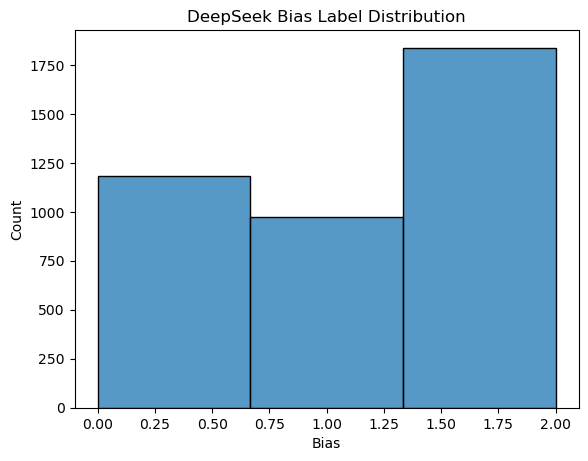

In [16]:
plt.figure(figsize=(6.5, 5), dpi=100)
sns.histplot(data=df_10k_cleaned, x="llm_bias_cat", bins=3, kde=False)
plt.title("DeepSeek Bias Label Distribution")
plt.xlabel("Bias")
plt.ylabel("Count")
plt.show()

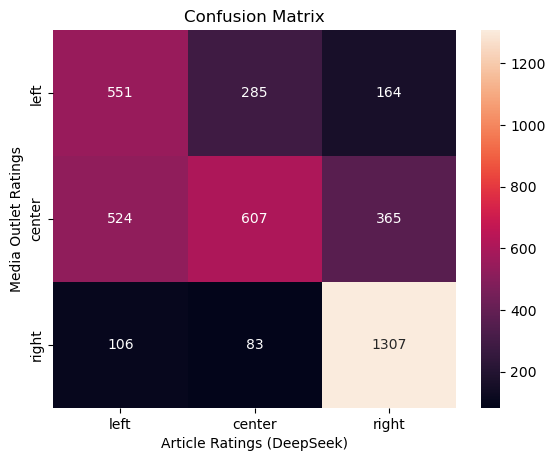

In [17]:
# Confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(6.5, 5), dpi=100)

cm = confusion_matrix(df_10k_cleaned["source_bias_cat"], df_10k_cleaned["llm_bias_cat"])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["left", "center", "right"], yticklabels=["left", "center", "right"])
plt.xlabel("Article Ratings (DeepSeek)")
plt.ylabel("Media Outlet Ratings")
plt.title("Confusion Matrix")
plt.show()

### Add llama labels

In [22]:
labels = pipeline(df_10k_cleaned["article_text"].tolist())

for label in labels:
    label["label"] = int(label["label"][-1])

In [23]:
df_labels = pd.DataFrame(labels)
df_labels.rename(columns={"label": "llama_bias"}, inplace=True)
df_10k_llama = pd.concat([df_10k_cleaned.reset_index(drop=True), df_labels], axis=1)
df_10k_llama

,id,interest_slug,story_id,title,description,date,url,lang,paywall,source_name,...,article_text,article_date_publish,article_authors,score,label,reasoning,source_bias_cat,llm_bias_cat,llama_bias,score
0,0,california-politics,ec08507a-0644-497a-8933-857281f6a95e,Los Angeles wildfires death toll rises as crew...,LOS ANGELES (AP) — The death toll from the wil...,2025-01-12T14:06:00.000Z,https://wtop.com/national/2025/01/los-angeles-...,en,no,Washington Top News,...,The National Weather Service issued red flag w...,2025-01-12 10:30:17,The Associated Press,-0.5,left-center,```markdown\nReasoning:\n\n- **Potentially Bia...,1,0,2,0.972436
1,1,big-ten,96c4a21f-2008-4d50-b29e-67ad8728dd31,Twelve-team playoff not big enough to avoid co...,"The new, 12-team College Football Playoff brin...",2024-12-08T22:40:20.000Z,https://www.limaohio.com/sports/2024/12/08/twe...,en,no,The Lima News,...,"The new, 12-team College Football Playoff brin...",2024-12-08 22:40:20,Associated Press; www.limaohio.com,0.0,center,```markdown\nReasoning:\n\n- **Potentially Bia...,1,1,0,0.875656
2,2,california-united-states,20855826-624f-4796-86c1-3bea0fd00649,LA mayor dismisses fire chief over response to...,"Six weeks after devastating wildfires, Los Ang...",2025-02-21T20:27:00.000Z,https://www.wdsu.com/article/los-angeles-mayor...,en,no,WDSU,...,that doesn't live there. Lynn McIntyre is one ...,2025-02-21 20:28:00,MICHAEL BLOOD,0.4,center-right,```markdown\nReasoning:\n\n- **Potentially Bia...,1,2,2,0.972169
3,3,gaming_d04843,35df203e-aeae-4bc4-86f2-d4d4a588c392,"Jason Momoa to play Lobo in new DC Universe, w...",The DC universe has cast another major role. J...,2024-12-30T10:18:14.000Z,https://www.digitaltrends.com/movies/jason-mom...,en,no,Digital Trends,...,Aquaman has left the building.\nAfter starring...,2024-12-30 10:18:14,Dan Girolamo,0.0,center,```markdown\nReasoning:\n\n- **Potentially Bia...,1,1,2,0.854036
4,4,2024-uk-election,370af72e-6a83-44a1-be1f-93175c43ab5f,UK Prime Minister Commits to Deploying Troops ...,"LONDON, ENGLAND (VINnews)-Prime Minister Keir ...",2025-02-17T12:40:57.000Z,https://vinnews.com/2025/02/17/uk-prime-minist...,en,no,VINnews,...,"LONDON, ENGLAND (VINnews)-Prime Minister Keir ...",2025-02-20 00:00:00,Reuven Rosenfeld,0.8,center-right,```markdown\nReasoning:\n\n- **Potentially Bia...,1,2,2,0.766677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3987,3995,egypt-economy,rss_45984_1735410902392_5,Egypt tests new extension of the Suez Canal,"President says due to “regional challenges”, c...",2024-12-30T00:59:59.000Z,https://www.dawn.com/news/1881890,en,no,Dawn,...,CAIRO: Egypt has tested a new 10-kilometre (6....,2024-12-30 00:00:00,Agencies; www.dawn.com,0.1,center,```markdown\nReasoning:\n\n- **Potentially Bia...,0,1,2,0.954245
3988,3996,spain,513ea92a-a153-4a8c-887b-6dde53bd1685,"Steve Bannon, former counselor of Donald Trump...","Jordan Bardella, who was to intervene at this ...",2025-02-21T14:03:23.000Z,https://www.francetvinfo.fr/monde/usa/presiden...,fr,no,France Info,...,"La seconde fois en un mois. Steve Bannon, anci...",2025-02-21 15:03:23,franceinfo,-1.5,left,```markdown\nReasoning:\n\n- **Potentially Bia...,0,0,0,0.845818
3989,3997,associated-press-news,b759e2da-8ca8-4b38-952a-5b43a51c4d96,Trump abruptly fires chairman of the Joint Chi...,The ouster of Gen. CQ Brown is sure to send sh...,2025-02-22T01:02:20.000Z,https://www.mercurynews.com/2025/02/21/trump-f...,en,no,The Mercury news,...,By TARA COPP and LOLITA C. BALDOR | Associated...,2025-02-22 01:02:20,The Associated Press; ssteade@bayareanewsgroup...,-0.8,left-center,```markdown\nReasoning:\n\n- **Potentially Bia...,0,0,1,0.994020
3990,3998,vienna-austria,1801c0ce-a457-408c-a10f-1da9154abdc2,Austria Arrests Teenager Over Foiled Plot to A...,"US News is a recognized leader in college, gra...",2025-02-19T08:02:00.000Z,https://www.usnews.com/news/world/articles/202...,en,yes,U.S. News,...,By Francois Murphy\nVIENNA (Reuters) -Aus

In [24]:
# Remove non-english entries
df_10k_llama = df_10k_llama[df_10k_llama["lang"] == "en"]

In [25]:
import csv

df_10k_llama.to_csv("../data/topics_10k_llama.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

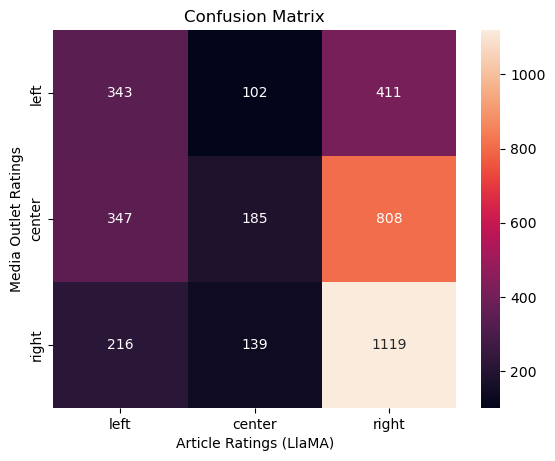

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(6.5, 5), dpi=100)

cm = confusion_matrix(df_10k_llama["source_bias_cat"], df_10k_llama["llama_bias"])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["left", "center", "right"], yticklabels=["left", "center", "right"])
plt.xlabel("Article Ratings (LlaMA)")
plt.ylabel("Media Outlet Ratings")
plt.title("Confusion Matrix")
plt.show()

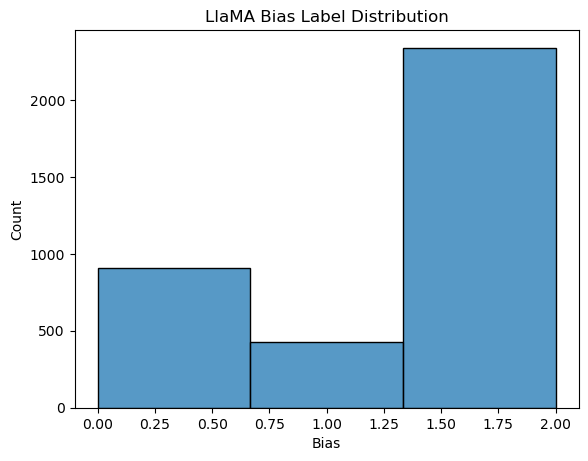

In [45]:
plt.figure(figsize=(6.5, 5), dpi=100)
sns.histplot(data=df_10k_llama, x="llama_bias", bins=3, kde=False)
plt.title("LlaMA Bias Label Distribution")
plt.xlabel("Bias")
plt.ylabel("Count")
plt.show()

In [27]:
def plot_media(df, name):
    media = df[df["source_name"] == name]
    source_bias = media["source_bias"].iloc[0]

    plt.figure(figsize=(6.5, 5), dpi=100)
    sns.histplot(data=media, x="llama_bias", bins=3, kde=True)
    plt.title(f"{name} ({source_bias}) Bias Distribution")
    plt.xlabel("Bias")
    plt.ylabel("Count")
    plt.show()

In [32]:
df_10k_llama["source_name"].value_counts().head(50)

thepatriotlight.com          168
The Gateway Pundit           146
WLTReport                    124
Crooks and Liars              90
World Socialist Web Site      75
realnewsnow.com               71
Twitchy                       59
newsaddicts.com               59
100% FED UP!                  58
WND                           58
Bossip                        49
The National Pulse            48
PJ Media                      47
The Thinking Conservative     45
Conservative Playlist         39
Geller Report                 38
vigilantnews.com              38
Wonkette                      35
Patriot Journal               31
Palmer Report                 31
LifeSiteNews                  30
Pacific Pundit                29
The Last Refuge               28
thepeoplesvoice.tv            27
The Published Reporter        26
Newsday                       22
KIFI                          22
BBC News                      21
American Lookout              21
Conservative Daily News       20
KVIA      

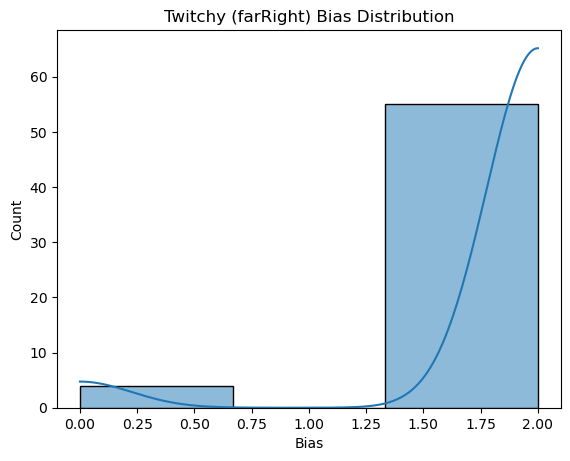

In [33]:
plot_media(df_10k_llama, "Twitchy")

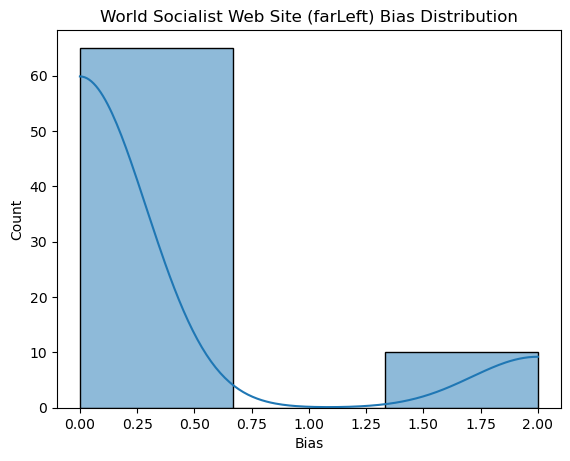

In [39]:
plot_media(df_10k_llama, "World Socialist Web Site")

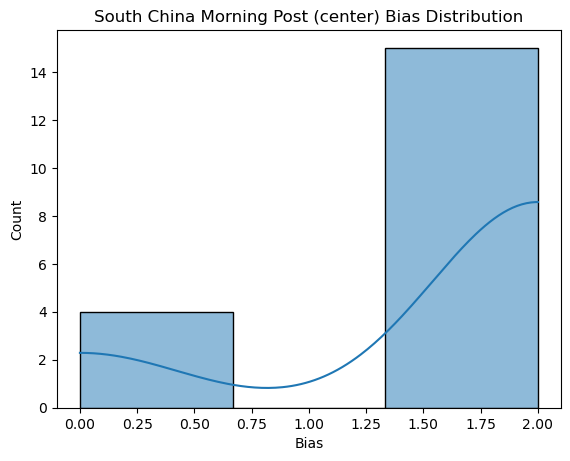

In [41]:
plot_media(df_10k_llama, "South China Morning Post")

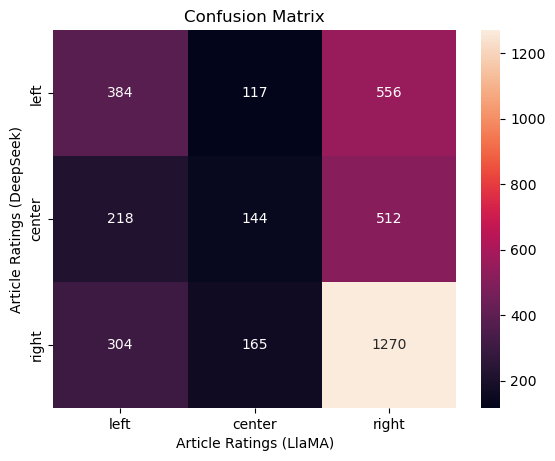

In [26]:
# Confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(6.5, 5), dpi=100)

cm = confusion_matrix(df_10k_llama["llm_bias_cat"], df_10k_llama["llama_bias"])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["left", "center", "right"], yticklabels=["left", "center", "right"])
plt.xlabel("Article Ratings (LlaMA)")
plt.ylabel("Article Ratings (DeepSeek)")
plt.title("Confusion Matrix")
plt.show()

In [154]:
# Consider DeepSeek labels as ground truth

from sklearn.metrics import classification_report

print(
    classification_report(
        df_10k_llama["llm_bias_cat"], df_10k_llama["llama_bias"],
        target_names=["left", "center", "right"],
    )
)

              precision    recall  f1-score   support

        left       0.42      0.36      0.39      1057
      center       0.34      0.16      0.22       874
       right       0.54      0.73      0.62      1739

    accuracy                           0.49      3670
   macro avg       0.44      0.42      0.41      3670
weighted avg       0.46      0.49      0.46      3670



In [47]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score

# Example DataFrame with two annotators' labels
# Calculate Cohen's Kappa
kappa_score = cohen_kappa_score(df_10k_llama["llm_bias_cat"], df_10k_llama["llama_bias"])
print(f"Cohen's Kappa Score: {kappa_score:.2f}")


Cohen's Kappa Score: 0.15
